In [1]:
import os
from tqdm import tqdm

import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat, reduce

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler

from transformers import AutoTokenizer, AutoConfig, AutoModel

from sklearn.metrics import accuracy_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(1111)

In [3]:
'''
main ref) https://www.kaggle.com/cdeotte/pytorch-bigbird-ner-cv-0-615?scriptVersionId=83230719
detr ref) https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb
detr ref) https://www.kaggle.com/tanulsingh077/end-to-end-object-detection-with-transformers-detr
코드 실행 전 준비 사항 :
    1) 먼저 kaggle 에서 데이터를 다운받고, './input' 에 압축해제 시켜준다.
    2) detr 을 fork 해준다. # !git clone https://github.com/facebookresearch/detr.git
'''

"\nmain ref) https://www.kaggle.com/cdeotte/pytorch-bigbird-ner-cv-0-615?scriptVersionId=83230719\ndetr ref) https://colab.research.google.com/github/facebookresearch/detr/blob/colab/notebooks/detr_demo.ipynb\ndetr ref) https://www.kaggle.com/tanulsingh077/end-to-end-object-detection-with-transformers-detr\n코드 실행 전 준비 사항 :\n    1) 먼저 kaggle 에서 데이터를 다운받고, './input' 에 압축해제 시켜준다.\n    2) detr 을 fork 해준다. # !git clone https://github.com/facebookresearch/detr.git\n"

In [4]:
# object detection 문제로 전처리하기
# objective : use DETR structure for sentence segmentation.
PATH = os.path.join(os.getcwd(), 'input')
TRAIN_NER_PATH_DETR = os.path.join(PATH, 'train_detr.csv')

In [5]:
# todo
#!# test code for preprocessing

In [6]:
# NER label 로 전처리한 데이터 불러오기
# 만약 starting class 를 원하지 않는다면 이하 코드를 실행할 것.

try:
    from ast import literal_eval
    train_text_df = pd.read_csv(TRAIN_NER_PATH_DETR)
    
    # pandas saves lists as string, we must convert back
    from ast import literal_eval
    train_text_df.segment_label = train_text_df.segment_label.apply(lambda x: literal_eval(x))
    
    original_train_df = pd.read_csv(os.path.join(PATH, 'train.csv'))
    
except:
    print('this is 1st time to run this code...')
    print('try to convert original text to DETR labels...')
    # read original text files0
    train_ids, train_texts = [], []
    for f in tqdm(list(os.listdir(os.path.join(PATH, 'train')))):
        train_ids.append(f.replace('.txt', ''))
        train_texts.append(open(os.path.join(PATH, 'train', f), 'r').read())
    train_text_df = pd.DataFrame({'id': train_ids, 'text': train_texts})

    # convert segment label into object detection label : [segment_type, x, y]
    original_train_df = pd.read_csv(os.path.join(PATH, 'train.csv'))
    label_list = []
    for i, text_df in tqdm(train_text_df.iterrows()):
        total = text_df['text'].split().__len__()
        segment_label_list = []
        for j, segment_df in original_train_df[original_train_df['id'] == text_df['id']].iterrows():
            segment_label = [
                segment_df['discourse_type'],
                int(segment_df['predictionstring'].split(' ')[0]), 
                int(segment_df['predictionstring'].split(' ')[-1])
            ]
            segment_label_list.append(segment_label)

        label_list.append(segment_label_list)

    train_text_df['segment_label'] = label_list
    train_text_df.to_csv(TRAIN_NER_PATH_DETR, index=False)

In [7]:
# CREATE DICTIONARIES THAT WE CAN USE DURING TRAIN AND INFER
output_labels_detr = [
    'O', # detr need dummy class for padding
    'Lead', 
    'Position', 
    'Claim', 
    'Counterclaim', 
    'Rebuttal', 
    'Evidence', 
    'Concluding Statement'
]

labels_to_ids = {v:k for k,v in enumerate(output_labels_detr)}
ids_to_labels = {k:v for k,v in enumerate(output_labels_detr)}

In [8]:
# CHOOSE VALIDATION INDEXES
IDS = original_train_df.id.unique()
print('There are',len(IDS),'train texts. We will split 90% 10% for validation.')

# TRAIN VALID SPLIT 90% 10%
train_idx = np.random.choice(np.arange(len(IDS)),int(0.9*len(IDS)),replace=False)
valid_idx = np.setdiff1d(np.arange(len(IDS)),train_idx)

# CREATE TRAIN SUBSET AND VALID SUBSET
data_df = train_text_df[['id','text', 'segment_label']]
train_df = data_df.loc[data_df['id'].isin(IDS[train_idx]),['text', 'segment_label']].reset_index(drop=True)
valid_df = data_df.loc[data_df['id'].isin(IDS[valid_idx])].reset_index(drop=True)

print("FULL Dataset: {}".format(data_df.shape))
print("TRAIN Dataset: {}".format(train_df.shape))
print("VALID Dataset: {}".format(valid_df.shape))

There are 15594 train texts. We will split 90% 10% for validation.
FULL Dataset: (15594, 3)
TRAIN Dataset: (14034, 2)
VALID Dataset: (1560, 3)


In [9]:
'''test code for preprocessing'''
i = 1
j = 0

# pre-processed
label, start_idx, end_idx = data_df['segment_label'][i][j]
text_id = data_df['id'][i]
print(data_df['text'][i].split()[start_idx:end_idx+1])

# original
original_text = original_train_df[original_train_df['id'] == text_id]
print(original_text[original_text['discourse_type'] == label]['discourse_text'])

['Venus', 'is', 'a', 'worthy', 'pursuit', 'despite', 'the', 'dangers.']
39834    Venus is a worthy pursuit despite the dangers 
Name: discourse_text, dtype: object


In [10]:
data_df.head()

,id,text,segment_label
0,7301B174090E,I believe that a B average would be a good thi...,"[[Position, 0, 14], [Claim, 32, 47], [Counterc..."
1,3799E21B6EC3,Venus is a worthy pursuit despite the dangers....,"[[Position, 0, 7], [Claim, 8, 28], [Evidence, ..."
2,29C5DBB0A339,Limiting car usage will have many advantages. ...,"[[Position, 0, 6], [Claim, 11, 12], [Claim, 14..."
3,1613BD216385,"""Making Mona Lisa Smile"" is about a computer h...","[[Lead, 0, 39], [Position, 40, 64], [Evidence,..."
4,D4A3E7EC982E,In this essay i will be explaining the differe...,"[[Lead, 0, 22], [Position, 23, 33], [Claim, 34..."


In [11]:
# dataset 이 잘 작동하는지 확인하는 코드
# #!# 로 표지된 index 를 바꿔주면 해당 dataset_row 에 대해서 전처리된 라벨과 실제 라벨에서 다른 부분을 출력해준다.

# data = data_df
# is_train = True

# index = 2 #!# 바꾸면서 다양한 시도 해보기

# text = data.text[index]        
# text_id = data.id[index]
# segment_label_list = data.segment_label[index] if is_train else None

# # TOKENIZE TEXT
# encoding = tokenizer(
#     text.split(),
#     is_split_into_words=True,
#     padding='max_length', #!# need to check exist seq s.t. longer than 4094
#     truncation=True, #!# need to check exist seq s.t. longer than 4094
#     max_length=500
# )
        
# word_ids = encoding.word_ids()

# segment_ids_list = [[labels_to_ids[label], start_idx, end_idx] for label, start_idx, end_idx in segment_label_list]

# processed_list = []
# for ids, start_idx, end_idx in segment_ids_list:
#     start_word_ids = word_ids.index(start_idx)
#     end_word_ids = word_ids.index(end_idx)
    
#     processed_list.append(tokenizer.decode(encoding.input_ids[start_word_ids:end_word_ids+1]))
    
# original_list = list(train_df[train_df['id'] == text_id]['discourse_text'])

# is_same = True
# for p_discourse, o_discourse in zip(processed_list, original_list):
#     if p_discourse.split() == o_discourse.split():
#         continue
        
#     else: 
#         is_same = False
#         for p, o in zip(p_discourse.split(), o_discourse.split()):
#             if p != o:
#                 print(p, o)
# if is_same:
#     print('every token in the label is same.')

In [12]:
'''baseline : ignore \n\n, 문장 기호들'''
#!# 문장 기호는 상당히 중요한 정보를 담고 있어서 처리해주고 싶은데.. 
class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, is_train):
        super(dataset, self).__init__()
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_train = is_train # if test (or validation) period, we won't use word label

    def __getitem__(self, index):
        global max_segment
        # GET TEXT AND WORD LABELS 
        text = self.data.text[index]        
        segment_label_list = self.data.segment_label[index] if self.is_train else None

        # TOKENIZE TEXT
        encoding = self.tokenizer(
            text.split(),
            is_split_into_words=True,
            return_offsets_mapping=False, #!# how to use it for enabling tokenizer to "see" \n\n?
            padding='max_length', #!# need to check exist seq s.t. longer than 4094
            truncation=True, #!# need to check exist seq s.t. longer than 4094
            max_length=self.max_len
        )
        
        word_ids = encoding.word_ids()
        
        # CREATE TARGETS
        #!# detr label padding 구현 : x, y 정보는 어떻게 넣어주는가? 0이어도 되나, random 이 더 좋으려나
        #!# 결론 : padding 은 구현 안함. loss 계산에서 누락. 필요하면 이하 코드 활용.
        #!# 근데, 또 null_object weight 같은걸 보면 아예 없지는 않은듯.... 어렵네
        if self.is_train:
            segment_ids_list = torch.as_tensor([[labels_to_ids[label], start_idx, end_idx] for label, start_idx, end_idx in segment_label_list]) # [num_seg, 3]
            segment_ids_pad  = torch.zeros(max_segment - segment_ids_list.size(0), segment_ids_list.size(1)) # [max_seg - num_seg, 3]
            segment_ids_list = torch.cat((segment_ids_list, segment_ids_pad), dim = 0) # [max_seg, 3]
            encoding['labels'] = segment_ids_list #!# .type(torch.LongTensor) # class, bound box must be long tensor

        # CONVERT TO TORCH TENSORS
        item = {k: torch.as_tensor(v) for k, v in encoding.items()}
        return item

    def __len__(self):
        return self.len

# build model

In [23]:
# ref) https://github.com/facebookresearch/detr 를 참고했으나, review 필요함.
class DetrHead(nn.Module):
    def __init__(self, feature_extractor, transformer, prediction_head, pos_emb, max_seq, max_segment, d_model):
        super(DetrHead, self).__init__()
        self.feature_extractor = feature_extractor
        self.transformer = transformer
        self.prediction_head = prediction_head
        
        self.feature_pos = pos_emb # absolute positional encoding (sinusodial, attention is all you need)
        self.query_pos = nn.Parameter(torch.rand(max_segment, d_model))
        
    def forward(self, x):
        out = self.feature_extractor(x) # x -> [b, s, d_model]
        out = self.transformer(out + self.feature_pos(out), repeat(self.query_pos, 'i j -> b i j', b = out.size(0))) # [b, s, d_model]
        out = self.prediction_head(out)
        return out
    
class FeatureExtractor(nn.Module):
    def __init__(self, lm):
        super(FeatureExtractor, self).__init__()
        self.lm = lm
        
    def forward(self, x):
        out = self.lm(input_ids = x['input_ids'], attention_mask = x['attention_mask']).last_hidden_state #!# todo : try other layer
        return out
    
class Transformer(nn.Module): #!# todo : change transformer structure with user defined transformer structure
    def __init__(self, d_model, nhead = 8, num_encoder_layers = 6, num_decoder_layers = 6, dim_feedforward = 256):
        super(Transformer, self).__init__()
        self.transformer = nn.Transformer( # https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html
            d_model, 
            nhead = nhead, 
            num_encoder_layers = num_encoder_layers, 
            num_decoder_layers = num_decoder_layers, 
            dim_feedforward = dim_feedforward,
            batch_first = True
        ) 
        
    def forward(self, f, q):
        out = self.transformer(f, q)
        return out

class PredictionHead(nn.Module): #!# todo : try diff. prediction head
    def __init__(self, d_model, num_class):
        super(PredictionHead, self).__init__()
        self.fc_layer_class = nn.Linear(d_model, num_class + 1) # +1 for null class
        self.fc_layer_segment = nn.Linear(d_model, 2)
        
    def forward(self, x):
        c = self.fc_layer_class(x)
        b = self.fc_layer_segment(x)
        return (c, b)
    
import math
class PositionalEmbedding(nn.Module): #!# ref) https://github.com/codertimo/BERT-pytorch
    def __init__(self, d_model, max_len):
        super().__init__()
        pe = torch.zeros(max_len, d_model, requires_grad = False).float()
        pos = torch.arange(0, max_len).float()
        div = (-(torch.arange(0, d_model, 2).float() / d_model) * math.log(10000.0)).exp()
        
        pe[:, 0::2] = torch.sin(torch.einsum('i,j->ij', pos, div))
        pe[:, 1::2] = torch.cos(torch.einsum('i,j->ij', pos, div))
        pe = rearrange(pe, 'i j -> () i j')
        
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return self.pe[:, :x.size(1)]

# Test code (model)

모든 부분을 믿지 마라. 확인할 수 있는 코드를 만드는 것도 능력이다.

작업중...

In [24]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
lm = AutoModel.from_pretrained('bert-base-uncased') #!# 제출을 위해 local 에 다운받는 과정 필요.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [25]:
train_dataset = dataset(train_df, tokenizer, lm.config.max_position_embeddings, is_train = True)
train_loader = DataLoader(train_dataset, batch_size = 2, shuffle = True)

valid_dataset = dataset(valid_df, tokenizer, lm.config.max_position_embeddings, is_train = True)
valid_loader = DataLoader(valid_dataset, batch_size = 2, shuffle = True)

In [26]:
'''model parameter'''
max_seq = lm.config.max_position_embeddings
d_model = lm.config.hidden_size

max_segment = 20
num_class = len(output_labels_detr)

FEATURE_EXTRACTOR = FeatureExtractor(lm)
TRANSFORMER = Transformer(d_model)
PREDICTION_HEAD = PredictionHead(d_model, num_class)
PE = PositionalEmbedding(d_model, max_seq)
DETR_HEAD = DetrHead(FEATURE_EXTRACTOR, TRANSFORMER, PREDICTION_HEAD, PE, max_seq, max_segment, d_model)

In [27]:
for batch in train_loader:
    break

batch = {k : v.to(device) for k, v in batch.items()}
DETR_HEAD.to(device)

out = DETR_HEAD(batch)

# Training

In [17]:
# define loss function
# fork ref) https://github.com/facebookresearch/detr/blob/091a817eca74b8b97e35e4531c1c39f89fbe38eb/models/detr.py#L83
# code ref) https://www.kaggle.com/tanulsingh077/end-to-end-object-detection-with-transformers-detr

In [16]:
# baseline 이 작동하는지 확인하기 위해 bert-base 활용
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
lm = AutoModel.from_pretrained('bert-base-uncased') #!# 제출을 위해 local 에 다운받는 과정 필요.

# tokenizer = AutoTokenizer.from_pretrained('./model')
# lm = AutoModel.from_pretrained('google/bigbird-roberta-base') #!# 제출을 위해 local 에 다운받는 과정 필요.

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
train_dataset = dataset(train_df, tokenizer, lm.config.max_position_embeddings, is_train = True)
train_loader = DataLoader(train_dataset, batch_size = 2, shuffle = True)

valid_dataset = dataset(valid_df, tokenizer, lm.config.max_position_embeddings, is_train = True)
valid_loader = DataLoader(valid_dataset, batch_size = 2, shuffle = True)

In [18]:
'''model parameter'''
max_seq = lm.config.max_position_embeddings
d_model = lm.config.hidden_size

max_segment = 20
num_class = len(output_labels_detr) - 1 # null-class
FEATURE_EXTRACTOR = FeatureExtractor(lm)
TRANSFORMER = Transformer(d_model)
PREDICTION_HEAD = PredictionHead(d_model, num_class)
PE = PositionalEmbedding(d_model, max_seq)
DETR_HEAD = DetrHead(FEATURE_EXTRACTOR, TRANSFORMER, PREDICTION_HEAD, PE, max_seq, max_segment, d_model)

In [28]:
'''hyper parameter'''
EPOCH = 5
LR = 2e-6
max_norm = 0.1 # gradient clipping

scheduler = None

# 이하는 작업중인 hyper-parameters
# null_class_coef = 0.5 #!# null class 학습이 전혀 안이뤄지는것도 문제가 있지... 지금은 전부 버리는데 이게 맞는 것 같지는 않아.

In [29]:
#!# 여기부터 facebook source code 를 바꾸고 있음.
#!# ref) https://github.com/facebookresearch/detr/blob/eb9f7e03ed8e2ed2cd55528989fe7df890bc3fc0/models/matcher.py#L12
#!# 각 코드가 잘 작동하는지 *매우* 유의해서 살펴봐야 함.
#!# facebook 에서는 @torch.no_grad() 를 사용해서 메모리를 적게 사용함. 나는 loss 를 compute_loss 에서 직접 계산하기 때문에 그게 안됨.
#!# 메모리 문제가 아슬아슬해지면 고려가 필요함.

from scipy.optimize import linear_sum_assignment

def compute_loss(outputs : dict, targets : dict, weight_bbox = 1, weight_class = 1, weight_giou = 1):
    '''Compute loss. 
    모델이 예측한 class 와 bounding box 를 토대로 target 과 비교해서 loss 를 계산한다.
    DETR 코드와 마찬가지로 target 에는 no-object class 가 없다. 즉, no-object 에 대해서는 loss 를 계산하지 않는다.
    # ref) https://github.com/facebookresearch/detr/blob/eb9f7e03ed8e2ed2cd55528989fe7df890bc3fc0/models/matcher.py#L12
    
    Parameters
        outputs:  
            - 'pred_logits': 각 class 에 대한 logit. 이후 softmax 를 통해 class 에 대한 확률 계산으로 사용된다.
            - 'pred_boxes' :  예측한 bounding box. [x, y] 로 이뤄진다.
        target:
            - 'labels': 해당 segment 의 class
            - 'boxes' : 해당 segment 의 bounding box [x, y]
            
    Returns
        bbox 에 대한 2가지 loss (L1 거리, iou) 와 cross entropy 를 합한 loss 를 뱉어준다.
        : cost_bbox + cost_class + cost_giou
    '''
    batch_size, num_query, num_tgt = outputs["pred_logits"].size(0), outputs["pred_logits"].size(1), targets['labels'].size(-1)

    # We flatten to compute the cost matrices in a batch
    out_prob = rearrange(outputs["pred_logits"], 'b s c -> (b s) c').softmax(dim = -1)  # [batch_size * num_queries, num_classes]
    out_bbox = rearrange(outputs["pred_boxes"], 'b s box -> (b s) box')  # [batch_size * num_queries, 4]

    # Also concat the target labels and boxes
    tgt_ids  = torch.cat([v for v in targets["labels"].type(torch.LongTensor)]).to(device)
    tgt_bbox = torch.cat([v for v in targets["boxes"]]).to(device)

    # Compute the classification cost. Contrary to the loss, we don't use the NLL,
    # but approximate it in 1 - proba[target class].
    # The 1 is a constant that doesn't change the matching, it can be ommitted.
    cost_class = -out_prob[:, tgt_ids]

    # Compute the L1 cost between boxes
    #!# 이거 normalize 안돼서 너무 클거임. 1/n_seq 해주는게 좋을 듯
    cost_bbox = torch.cdist(out_bbox, tgt_bbox, p=1) # [batch_size * num_queries, batch_size * num_queries]

    # Compute the giou cost betwen boxes
    #!# 분명 overflow 문제 발생함.. 어떻게 해결할 수 있을까. detr 은 assert 사용함
    cost_giou = -one_dim_iou(out_bbox, tgt_bbox)

    #!# Final cost matrix
    #!# need to change weight for loss
    C = weight_bbox * cost_bbox + weight_class * cost_class + weight_giou * cost_giou

    C = rearrange(C, '(b1 q1) (b2 q2) -> b1 q1 b2 q2', # [batch_size, num_query, batch_size, num_query]
                  b1 = batch_size, q1 = num_query, b2 = batch_size, q2 = num_tgt) 

    match_list = [linear_sum_assignment(C[b, :, b, :].detach().cpu()) for b in range(batch_size)]

    match_loss = torch.zeros(batch_size, num_query, num_query)
    for b in range(batch_size):
        for i, j in zip(match_list[b][0], match_list[b][1]): # index = (i, j)
            match_loss[b, i, j] = torch.as_tensor(C[b, i, b, j])
    
    return torch.sum(match_loss)

#!# 높은 확률로 div zero 로 인한 overflow 예상됨.
def one_dim_iou(out_bbox, tgt_bbox):
    max_matrix = torch.max(
        repeat(out_bbox, 'bq i -> bq r i', r = tgt_bbox.size(0)), 
        repeat(tgt_bbox, 'bq i -> r bq i', r = out_bbox.size(0))
    )

    min_matrix = torch.min(
        repeat(out_bbox, 'bq i -> bq r i', r = tgt_bbox.size(0)), 
        repeat(tgt_bbox, 'bq i -> r bq i', r = out_bbox.size(0))
    )

    return (min_matrix[:, :, 1] - max_matrix[:, :, 0]) / (max_matrix[:, :, 1] - min_matrix[:, :, 0])

In [30]:
weight_dict = {'weight_bbox' : 1/max_seq, 'weight_class' : 1, 'weight_giou' : 1/max_seq}
optimizer = torch.optim.AdamW(DETR_HEAD.parameters(), lr=LR)

loss_traj = []

model = DETR_HEAD.to(device)
model.train()

for i, batch in enumerate(train_loader):
    batch = {k : v.to(device) for k, v in batch.items()}
    
    c, b = DETR_HEAD(batch) # c : class, b : bounding box
    out = {'pred_logits' : c, 'pred_boxes' : b}
    tgt = {'labels' : batch['labels'][:, :, 0], 'boxes' : batch['labels'][:, :, 1:]}

    loss = compute_loss(out, tgt, **weight_dict)
    
    optimizer.zero_grad()
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
    optimizer.step()
    
    if scheduler is not None:
        scheduler.step()
    
    loss_traj.append(float(loss))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


ValueError: matrix contains invalid numeric entries

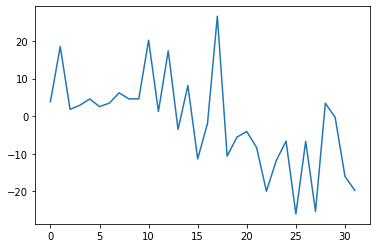

In [31]:
plt.plot(loss_traj)

# todo

In [ ]:
# code for submission
# ref) https://www.kaggle.com/cdeotte/pytorch-bigbird-ner-cv-0-615?scriptVersionId=83230719
test_names, test_texts = [], []
for f in list(os.listdir('../input/feedback-prize-2021/test')):
    test_names.append(f.replace('.txt', ''))
    test_texts.append(open('../input/feedback-prize-2021/test/' + f, 'r').read())
test_texts = pd.DataFrame({'id': test_names, 'text': test_texts})

test_names, train_texts = [], []
for f in tqdm(list(os.listdir('../input/feedback-prize-2021/train'))):
    test_names.append(f.replace('.txt', ''))
    train_texts.append(open('../input/feedback-prize-2021/train/' + f, 'r').read())
train_text_df = pd.DataFrame({'id': test_names, 'text': train_texts})


# # TEST DATASET
# test_texts_set = dataset(test_texts, tokenizer, config['max_length'], True)
# test_texts_loader = DataLoader(test_texts_set, **test_params)

In [38]:
# define config
config = {'model_name': MODEL_NAME,   
          'max_length': 1024,
          'train_batch_size':4,
          'valid_batch_size':4,
          'epochs':5,
          'learning_rates': [2.5e-5, 2.5e-5, 2.5e-6, 2.5e-6, 2.5e-7],
          'max_grad_norm':10,
          'device': 'cuda' if cuda.is_available() else 'cpu'}

In [13]:
# if you are first running this code, please download LM.
MODEL_NAME = 'google/bigbird-roberta-base' # choose which model to download
DOWNLOADED_MODEL_PATH = 'model'            # choose where to download the model

if DOWNLOADED_MODEL_PATH == 'model':
    os.mkdir('model')
    
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, add_prefix_space=True) #!# add_prefix_space?
    tokenizer.save_pretrained('model')

    config_model = AutoConfig.from_pretrained(MODEL_NAME) 
    config_model.num_labels = 15
    config_model.save_pretrained('model')

    backbone = AutoModelForTokenClassification.from_pretrained(MODEL_NAME, 
                                                               config=config_model)
    backbone.save_pretrained('model')

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/760 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/846k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/775 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/513M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/bigbird-roberta-base were not used when initializing BigBirdForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BigBirdForTokenClassification were no

In [173]:
#!# implement tokenizer \n\n, to see paragraph information
# ref) https://github.com/huggingface/tokenizers/issues/247
# ref) https://www.kaggle.com/c/feedback-prize-2021/discussion/296713
tokenizer.decode(tokenizer(r'\\n\\n', return_offsets_mapping=True)['input_ids'])

'''add new special token to model and tokenizer'''
special_tokens_dict = {'additional_special_tokens': [r'\\n\\n']}
num_added_toks = tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))


def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i) 
        label_ids = []
        for word_idx in word_ids:                
            if word_idx is None:
                label_ids.append(-100)
            else:  
                label_ids.append(label[word_idx])

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs